# 생산량(Fruits number) 및 생장량(Leaves length) 예측 모델 만들기

In [1]:
import os
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

from utils import getCode

serviceKey = '923f389b2ca44295a07f14d1828aee0e'

## 전처리

### 1. 생육정보(cultivate)와 환경정보(seasonenv)가 동시에 존재하는 농가 탐색
논문에서는 총 245개 농가 중 15개가 선택됨

In [2]:
#모든 농가의 cultivate data를 모아둔 file
cultivate_file = pd.read_csv('./data/all_cultivate_df.csv', index_col=0)
cultivate_user_list = list(set(cultivate_file['userId']))
#각 농가의 환경정보
env_file_list=os.listdir(r'C:\Users\youjeongsue\Desktop\study\4-2\스마트팜(소융캡&창종설)\data\seasonenv')

#두 정보가 모두 있는 농가만 선택한다.
target_user = []
for user in env_file_list:
    if user[:-4] in cultivate_user_list:
        target_user.append(user)

In [3]:
#총 50개 농가
len(target_user)

50

### 2. 데이터가 부실한 농가 제외
환경정보(seasonenv) 데이터 수가 100개 미만인 경우, 생육정보(cultivate)가 없는 경우 삭제 -> 35개(target_user_3)<br>
논문에서 사용한 6가지 환경변수가 모두 있는 경우만 선택 -> 10개(target_user_4)

In [3]:
#환경정보로 거른 것
target_user_2 = []

def splitDate(series):
    return series.split(" ")[0]

for user in target_user:
    data = pd.read_csv('./data/seasonenv/'+user, index_col=0)
    data['date']=data['measDate'].agg(splitDate)
    if len(data.groupby('date').count()) >= 100:
        target_user_2.append(user)
        print(len(data.groupby('date').count()), list(data.loc[:,'date'])[0], list(data.loc[:, 'date'])[-1])

342 2017-01-01 2017-12-08
218 2017-01-01 2017-08-07
246 2017-01-01 2017-09-03
277 2017-01-01 2017-10-04
289 2018-08-26 2019-06-27
318 2018-07-21 2019-06-18
349 2018-06-25 2019-06-23
330 2018-08-06 2019-07-17
325 2018-07-20 2019-06-25
280 2018-08-14 2019-05-22
194 2018-09-20 2019-04-02
155 2019-12-21 2020-06-13
195 2019-10-31 2020-05-12
192 2019-11-05 2020-05-14
142 2019-12-27 2020-05-16
212 2019-10-31 2020-05-29
244 2019-11-01 2020-07-01
214 2019-11-07 2020-06-28
216 2019-11-18 2020-06-20
143 2019-11-11 2020-04-18
128 2019-11-27 2020-04-17
190 2019-12-18 2020-07-01
169 2019-12-24 2020-06-09
221 2019-11-22 2020-06-29
102 2020-04-15 2020-07-31
190 2019-12-18 2020-06-27
246 2019-11-25 2020-07-27
206 2019-12-18 2020-07-15
174 2019-12-26 2020-07-15
202 2019-12-24 2020-07-13
229 2019-12-18 2020-08-05
248 2019-11-15 2020-07-19
135 2020-01-08 2020-05-29
147 2019-12-24 2020-05-29
132 2020-01-13 2020-05-24


In [4]:
#생육정보로 거른 것
target_user_3=[]
for user in target_user_2:
    try:
        data=cultivate_file[cultivate_file['userId']==user[:-4]]
        data['date']=data['measDate'].agg(splitDate)
        target_user_3.append(user)
        print(len(data.groupby('date').count()), list(data.loc[:,'date'])[0], list(data.loc[:,'date'])[-1])
    except:
        pass

13 2017-03-19 2017-06-11
16 2017-03-05 2017-05-28
11 2017-03-26 2017-05-07
13 2017-03-12 2017-05-28
36 2018-10-14 2019-06-19
36 2018-10-14 2019-06-18
33 2018-10-14 2019-06-24
31 2018-10-14 2019-06-05
36 2018-10-14 2019-06-28
37 2018-10-08 2019-06-03
23 2018-11-19 2019-03-20
24 2020-01-01 2020-05-29
26 2019-12-27 2020-05-29
26 2019-12-09 2020-06-05
24 2019-12-09 2020-04-27
26 2019-12-16 2020-06-01
23 2019-11-03 2020-03-29
31 2019-11-10 2020-05-31
25 2019-12-16 2020-05-25
32 2019-11-04 2020-05-18
27 2019-12-07 2020-05-30
26 2019-12-18 2020-05-29
11 2019-12-07 2020-02-08
26 2019-12-07 2020-05-30
25 2019-12-10 2020-05-18
27 2019-12-15 2020-06-06
23 2020-01-06 2020-05-04
26 2019-12-14 2020-05-16


In [6]:
#총 농가 수
len(target_user_3)

28

In [5]:
#논문에서 활용한 환경변수 6가지
codes = ['TE','CI','HI','TI','EL','HL']
for code in codes:
    print(getCode(code))

외부온도
내부CO2
내부습도
내부온도
토양EC
지습


In [6]:
#농가에서 사용한 6가지 코드가 모두 있는 경우만 색출
target_user_4 = []
for user in target_user_3:
    data = pd.read_csv('./data/seasonenv/'+user, index_col=0)
    data.head()
    num=0
    valid_code_list=[]
    for code in list(set(data['fatrCode'])):
        if code in codes:
            num+=1
            valid_code_list.append(code)
    if num>=6:
        target_user_4.append(user)
    print(num, valid_code_list)
print("===result===")
print(target_user_4)

6 ['EL', 'HL', 'TI', 'CI', 'TE', 'HI']
6 ['EL', 'HL', 'TI', 'CI', 'TE', 'HI']
5 ['TI', 'HL', 'TE', 'HI', 'CI']
6 ['EL', 'HL', 'TI', 'CI', 'TE', 'HI']
5 ['CI', 'HL', 'TI', 'TE', 'HI']
5 ['HL', 'TI', 'TE', 'HI', 'CI']
5 ['TI', 'HL', 'TE', 'HI', 'CI']
5 ['CI', 'HL', 'TI', 'TE', 'HI']
5 ['HL', 'TI', 'TE', 'HI', 'CI']
5 ['HL', 'TI', 'TE', 'HI', 'CI']
5 ['HL', 'CI', 'TI', 'TE', 'HI']
6 ['EL', 'HL', 'TI', 'TE', 'HI', 'CI']
6 ['EL', 'CI', 'HL', 'TI', 'TE', 'HI']
6 ['EL', 'HL', 'TI', 'CI', 'TE', 'HI']
6 ['EL', 'TI', 'HL', 'CI', 'TE', 'HI']
6 ['EL', 'HL', 'TI', 'CI', 'TE', 'HI']
5 ['HL', 'TI', 'TE', 'HI', 'CI']
5 ['TI', 'HL', 'TE', 'HI', 'CI']
6 ['EL', 'HL', 'TI', 'TE', 'HI', 'CI']
5 ['HL', 'TI', 'TE', 'HI', 'CI']
5 ['HL', 'TI', 'TE', 'HI', 'CI']
5 ['HL', 'TI', 'TE', 'HI', 'CI']
5 ['HL', 'TI', 'TE', 'HI', 'CI']
5 ['TI', 'HL', 'TE', 'HI', 'CI']
5 ['HL', 'CI', 'TI', 'TE', 'HI']


KeyError: 'fatrCode'

In [7]:
for user in target_user_4:
    data=cultivate_file[cultivate_file['userId']==user[:-4]]
    data['date']=data['measDate'].agg(splitDate)
    print(len(data.groupby('date').count()), list(data.loc[:,'date'])[0], list(data.loc[:,'date'])[-1])

13 2017-03-19 2017-06-11
16 2017-03-05 2017-05-28
13 2017-03-12 2017-05-28
24 2020-01-01 2020-05-29
26 2019-12-27 2020-05-29
26 2019-12-09 2020-06-05
24 2019-12-09 2020-04-27
26 2019-12-16 2020-06-01
25 2019-12-16 2020-05-25


### 3. 환경변수 전처리: 주별 평균
선택된 농가의 환경변수 및 작기정보 데이터를 주별 평균으로 전처리한다.

In [8]:
#각 농가의 데이터수
num=0
for user in target_user_4:
    data = pd.read_csv('./data/seasonenv/'+user, index_col=0)
    data['date']=data['measDate'].agg(splitDate)
    num+=len(data.groupby('date').count())
    print(len(data.groupby('date').count()), list(data.loc[:,'date'])[0], list(data.loc[:, 'date'])[-1])
print(num)

342 2017-01-01 2017-12-08
218 2017-01-01 2017-08-07
277 2017-01-01 2017-10-04
155 2019-12-21 2020-06-13
195 2019-10-31 2020-05-12
192 2019-11-05 2020-05-14
142 2019-12-27 2020-05-16
212 2019-10-31 2020-05-29
221 2019-11-22 2020-06-29
1954


In [9]:
target_env = pd.read_csv('./data/seasonenv/'+target_user_4[0], index_col=0)
for i in range(len(target_user_4)-1):
    file = pd.read_csv('./data/seasonenv/'+target_user_4[i+1], index_col=0)
    target_env=target_env.append(file)
target_env

,fatrCode,facilityId,measDate,fldCode,sectCode,itemCode,senVal,ymd,cntCollect,num,totalRows,totalPage,currentPage
0,RP,PF_0000227_01,2017-01-01 00:00:00,FG,EO,80300,0.00,20170101,26,1,90376.0,91.0,1.0
1,WD,PF_0000227_01,2017-01-01 00:00:00,FG,EO,80300,48.96,20170101,26,2,NaN,NaN,NaN
2,IR,PF_0000227_01,2017-01-01 00:00:00,FG,EI,80300,0.00,20170101,26,3,NaN,NaN,NaN
3,HL,PF_0000227_01,2017-01-01 00:00:00,FG,EL,80300,91.38,20170101,26,4,NaN,NaN,NaN
4,TI,PF_0000227_01,2017-01-01 00:00:00,FG,EI,80300,13.20,20170101,26,5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91995,TE,PF_0010019_01,2020-06-29 06:00:00,FG,EO,80300,22.71,20200629,20,90996,NaN,NaN,NaN
91996,WS,PF_0010019_01,2020-06-29 06:00:00,FG,EO,80300,0.92,20200629,14,90997,NaN,NaN,NaN
91997,TI,PF_0010019_01,2020-06-29 06:00:00,FG,EI,80300,23.30,20200629,20,90998,NaN,NaN,NaN
91998,TL,PF_0010019_01,2020-06-29 06:00:00,FG,NT,80300,90.00,20200629,20,90999,NaN,NaN,NaN


In [21]:
set(target_env['facilityId'])

{'PF_0000227_01',
 'PF_0000304_01',
 'PF_0001405_01',
 'PF_0006023_01',
 'PF_0006024_01',
 'PF_0006025_01',
 'PF_0006042_01',
 'PF_0006043_01',
 'PF_0010019_01'}

In [12]:
#데이터 저장
target_env.to_csv("./data/target_env.csv")

In [10]:
g1=target_env[['senVal','ymd','fatrCode']].groupby(['fatrCode','ymd']).mean()
g1

senVal
fatrCode ymd                 
CI       20170101  508.454028
         20170102  489.247639
         20170103  484.931528
         20170104  504.773488
         20170105  487.321389
...                       ...
WS       20200625    1.126667
         20200626    1.119130
         20200627    0.870000
         20200628    1.411250
         20200629    0.872857

[7990 rows x 1 columns]

In [11]:
target_env_mean = pd.DataFrame(columns=list(set(target_env['fatrCode'])))
target_env_mean = target_env_mean.append([0]*73)
del_code=[]
count=0
num=0
for code in list(set(target_env['fatrCode'])):
    senVal=[]
    for val in list(g1.T[code].iloc[0,:]):
        if count==7:
            senVal.append(num/7)
            num=0
            count=0
        else:
            num+=val
            count+=1
    if(len(senVal)==73):
        target_env_mean[code]=senVal
    else:
        del_code.append(code)
target_env_mean

,0,CI,EI,EL,EO,HE,HI,HL,IR,PI,PL,PO,RP,SI,SO,TE,TI,TL,WD,WS
0,0.0,72.636290,NaN,NaN,NaN,NaN,49.967399,96.736294,NaN,NaN,NaN,NaN,25.719881,NaN,NaN,4.481683,34.992258,7.973964,65.725777,0.264881
1,0.0,480.488058,NaN,NaN,NaN,NaN,90.765456,97.073433,NaN,NaN,NaN,NaN,0.043016,NaN,NaN,1.263909,16.630754,5.191944,106.135198,1.768066
2,0.0,500.075556,NaN,NaN,NaN,NaN,89.314087,97.009385,NaN,NaN,NaN,NaN,0.018532,NaN,NaN,-0.200179,16.047857,5.125377,113.552242,1.966349
3,0.0,504.383671,NaN,NaN,NaN,NaN,90.506032,96.968214,NaN,NaN,NaN,NaN,0.035397,NaN,NaN,1.133333,16.234881,5.184881,129.812302,1.946726
4,0.0,487.585020,NaN,NaN,NaN,NaN,93.418036,97.273750,NaN,NaN,NaN,NaN,0.044921,NaN,NaN,2.863705,16.104517,5.061732,137.100013,1.885604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0.0,490.117137,NaN,NaN,NaN,NaN,73.448929,0.000000,NaN,NaN,NaN,NaN,0.051310,NaN,NaN,19.452937,22.029901,33.000000,4.627884,1.387722
69,0.0,453.843968,NaN,NaN,NaN,NaN,71.184326,0.000000,NaN,NaN,NaN,NaN,0.022163,NaN,NaN,21.925594,23.098497,65.925466,5.294480,1.173716
70,0.0,357.824940,NaN,NaN,NaN,NaN,75.023661,0.000000,NaN,NaN,NaN,NaN,0.018036,NaN,NaN,26.235774,25.866548,90.000000,5.086696,1.147768
71,0.0,370.756637,NaN,NaN,NaN,NaN,80.280313,0.000000,NaN,NaN,NaN,NaN,0.179508,NaN,NaN,24.511682,26.815893,90.000000,5.351146,1.084587


In [12]:
for delcode in del_code:
    del target_env_mean[delcode]

In [13]:
del target_env_mean[0]

In [14]:
target_env_mean

,CI,HI,HL,RP,TE,TI,TL,WD,WS
0,72.636290,49.967399,96.736294,25.719881,4.481683,34.992258,7.973964,65.725777,0.264881
1,480.488058,90.765456,97.073433,0.043016,1.263909,16.630754,5.191944,106.135198,1.768066
2,500.075556,89.314087,97.009385,0.018532,-0.200179,16.047857,5.125377,113.552242,1.966349
3,504.383671,90.506032,96.968214,0.035397,1.133333,16.234881,5.184881,129.812302,1.946726
4,487.585020,93.418036,97.273750,0.044921,2.863705,16.104517,5.061732,137.100013,1.885604
...,...,...,...,...,...,...,...,...,...
68,490.117137,73.448929,0.000000,0.051310,19.452937,22.029901,33.000000,4.627884,1.387722
69,453.843968,71.184326,0.000000,0.022163,21.925594,23.098497,65.925466,5.294480,1.173716
70,357.824940,75.023661,0.000000,0.018036,26.235774,25.866548,90.000000,5.086696,1.147768
71,370.756637,80.280313,0.000000,0.179508,24.511682,26.815893,90.000000,5.351146,1.084587


In [15]:
target_cultivate = cultivate_file[cultivate_file['userId'].isin(temp_user)]
target_cultivate.head()

NameError: name 'temp_user' is not defined

In [16]:
dellist=['statusCode',
 'statusMessage',
 'itemCode',
  'sampleNum',
 'harvestPosition',
 'ped',
 'solarCorrection',
 'fruitsWeight']
for delcode in dellist:
    del target_cultivate[delcode]

NameError: name 'target_cultivate' is not defined

In [17]:
target_cultivate['date']=target_cultivate['measDate'].agg(splitDate)

NameError: name 'target_cultivate' is not defined

In [18]:
target_cultivate_mean=target_cultivate.groupby('date').mean()
target_cultivate_mean.index=[i for i in range(73)]
target_cultivate_mean

NameError: name 'target_cultivate' is not defined

In [338]:
env_cultivate_mean_data = pd.concat([target_env_mean, target_cultivate_mean], axis=1)
env_cultivate_mean_data

,CI,EL,HI,HL,RP,TE,TI,TL,WD,WS,growLength,flowerTop,stemDiameter,leavesLength,leavesWidth,leavesNum,flowerPosition,fruitsPosition,fruitsNum
0,429.870952,4.750984,153.396753,55.303972,6.904804,4.560532,13.705495,2.317982,50.623234,42.811071,0.000000,21.750000,10.125000,42.125000,40.250000,11.750000,7.0250,5.200000,15.250000
1,484.114583,6.653175,90.717024,96.955337,0.043016,2.675000,16.408155,5.429140,106.135198,1.911647,13.750000,18.375000,10.225000,41.250000,39.000000,12.500000,7.0250,5.350000,15.500000
2,507.021746,6.658909,89.587123,96.916190,0.018532,-0.205377,16.056726,5.095575,113.552242,1.917937,4.000000,23.375000,10.581250,41.875000,40.625000,13.000000,6.1500,4.812500,14.250000
3,497.538552,6.650337,90.984444,96.955813,0.035397,0.646349,16.237738,5.097083,129.812302,1.837440,17.125000,28.937500,11.431250,42.500000,40.875000,13.875000,6.5625,5.050000,15.000000
4,483.562359,6.634325,93.566726,97.205040,0.044921,2.629261,16.126481,5.165720,137.100013,1.819652,89.083333,24.358333,9.894167,40.233333,36.258333,15.000000,9.0500,3.825000,11.416667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,463.937004,2.558988,73.735099,0.000000,0.051310,18.909385,21.812937,33.000000,4.627884,1.333307,0.583333,0.000000,9.991667,39.416667,34.000000,9.500000,0.0000,11.416667,25.250000
69,399.002322,2.619762,70.125784,0.000000,0.022163,21.503144,23.382624,33.354037,5.294480,1.170039,1.325000,10.362500,5.328750,25.962500,22.725000,16.250000,4.9625,22.207500,54.000000
70,363.941905,2.529940,74.134107,0.000000,0.018036,26.123601,26.655982,90.000000,5.086696,1.140103,0.000000,0.000000,10.405833,41.916667,34.833333,8.506667,0.0000,11.500000,15.833333
71,329.115833,2.521071,80.925402,0.000000,0.179508,24.499866,26.516548,90.000000,5.351146,1.147639,0.000000,0.000000,0.000000,11.250000,8.250000,18.750000,9.0050,8.105000,4.000000


In [343]:
def minmax(series, code):
    maxval = env_cultivate_mean_data[code].max()
    minval = env_cultivate_mean_data[code].min()
    return (series-minval)/(maxval-minval)

env_cultivate_mean_data_minmax = env_cultivate_mean_data.copy()
minmax_list=list(env_cultivate_mean_data.columns)
minmax_list.remove('leavesLength')
minmax_list.remove('fruitsNum')

for code in minmax_list:
    env_cultivate_mean_data_minmax[code]=env_cultivate_mean_data_minmax[code].agg(minmax, code=code)

In [344]:
env_cultivate_mean_data_minmax

,CI,EL,HI,HL,RP,TE,TI,TL,WD,WS,growLength,flowerTop,stemDiameter,leavesLength,leavesWidth,leavesNum,flowerPosition,fruitsPosition,fruitsNum
0,0.393531,0.480999,1.000000,0.568643,0.018794,0.175272,0.088176,0.033368,0.098633,1.000000,0.000000,0.746781,0.606439,42.125000,0.962406,0.362694,0.348246,0.065606,15.250000
1,0.515118,0.673581,0.280505,0.996909,0.000117,0.105929,0.264831,0.067667,0.216820,0.040451,0.069909,0.630901,0.612428,41.250000,0.924812,0.409326,0.348246,0.068199,15.500000
2,0.566465,0.674161,0.267535,0.996506,0.000050,0.000000,0.241860,0.063989,0.232611,0.040599,0.020337,0.802575,0.633766,41.875000,0.973684,0.440415,0.304870,0.058908,14.250000
3,0.545208,0.673294,0.283574,0.996914,0.000096,0.031323,0.253692,0.064006,0.267229,0.038710,0.087069,0.993562,0.684677,42.500000,0.981203,0.494819,0.325319,0.063013,15.000000
4,0.513880,0.671672,0.313216,0.999476,0.000122,0.104247,0.246420,0.064763,0.282745,0.038293,0.452928,0.836338,0.592613,40.233333,0.842356,0.564767,0.448631,0.041839,11.416667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0.469890,0.259077,0.085571,0.000000,0.000140,0.702968,0.618106,0.371616,0.000708,0.026883,0.002966,0.000000,0.598453,39.416667,0.774436,0.222798,0.000000,0.173062,25.250000
69,0.324339,0.265230,0.044140,0.000000,0.000060,0.798357,0.720706,0.375519,0.002127,0.023052,0.006737,0.355794,0.319166,25.962500,0.435338,0.642487,0.246003,0.359584,54.000000
70,0.245751,0.256136,0.090151,0.000000,0.000049,0.968279,0.934664,1.000000,0.001685,0.022350,0.000000,0.000000,0.623259,41.916667,0.799499,0.161036,0.000000,0.174503,15.833333
71,0.167688,0.255238,0.168108,0.000000,0.000489,0.908565,0.925550,1.000000,0.002248,0.022527,0.000000,0.000000,0.000000,11.250000,0.000000,0.797927,0.446400,0.115819,4.000000


## env_cultivate_mean_data_minmax를 이용한 예측 모델
1. 주별 전처리 후 train/test 분리 x
2. 주별 전처리(농가 별) 후 train/test 분리
3. 일별 전처리

In [347]:
columns=list(env_cultivate_mean_data_minmax.columns)
columns.remove('leavesLength')
columns.remove('fruitsNum')

In [434]:
def printScores(model, x, y):
    print("R^2: ",model.score(x, y))
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    mae = cross_val_score(model, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    mae = np.absolute(mae)
    rmse = cross_val_score(model, x, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
    rmse = np.absolute(rmse)
    print('Mean MAE: %.3f (%.3f)' % (mean(mae), std(mae)))
    print('Mean RMSE: %.3f' % (mean(rmse)))

In [333]:
#scoring options
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

### 1. OLS(statsmodels.OLS)

In [547]:
import statsmodels.api as sm

x=env_cultivate_mean_data_minmax[columns[:-1]]
y=env_cultivate_mean_data_minmax['leavesLength']
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           leavesLength   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                              959.0
Date:                Fri, 20 Nov 2020   Prob (F-statistic):                    3.64e-63
Time:                        06:40:36   Log-Likelihood:                         -161.41
No. Observations:                  73   AIC:                                      354.8
Df Residuals:                      57   BIC:                                      391.5
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
CI                 6.9950      2.415      2.897      0.005       2.160      11.830
EL                -7.0209      2.901     -2.420      0.019     -12.830      -1.212
HI                -4.0279      6.715     -0.600      0.551     -17.475       9.419
HL                 5.0123      3.532      1.419      0.161      -2.060      12.085
RP                -7.6899      6.564     -1.172      0.246     -20.834       5.454
TE                12.3581      3.330      3.711      0.000       5.690      19.026
TI                -7.2120      4.266     -1.690      0.096     -15.755       1.331
TL                 5.9858      2.925      2.046      0.045       0.128      11.844
WD                10.9095      7.727      1.412      0.163      -4.564      26.383
WS                 4.7385      6.529      0.726      0.471      -8.336      17.813
growLength         2.3541      1.961      1.201      0.235      -1.572       6.281
flowerTop         -2.2333      1.970     -1.134      0.262      -6.178       1.711
stemDiameter      15.0096      3.424      4.384      0.000       8.154      21.866
leavesWidth       26.1293      2.899      9.013      0.000      20.324      31.935
leavesNum          4.3028      1.788      2.407      0.019       0.723       7.883
flowerPosition     7.9929      2.209      3.619      0.001       3.570      12.416
==============================================================================
Omnibus:                        2.337   Durbin-Watson:                   2.324
Prob(Omnibus):                  0.311   Jarque-Bera (JB):                1.607
Skew:                           0.306   Prob(JB):                        0.448
Kurtosis:                       3.392   Cond. No.                         60.6
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

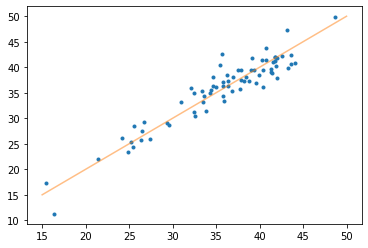

In [548]:
plt.plot(model.predict(x), y, '.')
plt.plot([15,50],[15,50], alpha=0.5);

In [523]:
x=env_cultivate_mean_data_minmax[columns[:-1]]
y=env_cultivate_mean_data_minmax['fruitsNum']
model = sm.OLS(y, x).fit()
print_model = model.summary()
print_model

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              fruitsNum   R-squared (uncentered):                   0.895
Model:                            OLS   Adj. R-squared (uncentered):              0.866
Method:                 Least Squares   F-statistic:                              30.39
Date:                Fri, 20 Nov 2020   Prob (F-statistic):                    4.41e-22
Time:                        06:38:33   Log-Likelihood:                         -291.88
No. Observations:                  73   AIC:                                      615.8
Df Residuals:                      57   BIC:                                      652.4
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
CI                36.8994     14.421      2.559      0.013       8.022      65.777
EL               -37.1248     17.326     -2.143      0.036     -71.819      -2.431
HI                11.4531     40.107      0.286      0.776     -68.860      91.766
HL                15.8295     21.094      0.750      0.456     -26.411      58.069
RP                75.8198     39.203      1.934      0.058      -2.683     154.322
TE                31.3875     19.887      1.578      0.120      -8.435      71.210
TI               -10.3162     25.481     -0.405      0.687     -61.341      40.709
TL               -23.6233     17.471     -1.352      0.182     -58.609      11.362
WD               -83.0245     46.149     -1.799      0.077    -175.437       9.388
WS               -20.6704     38.994     -0.530      0.598     -98.755      57.415
growLength        21.4552     11.711      1.832      0.072      -1.995      44.905
flowerTop         -5.6250     11.764     -0.478      0.634     -29.183      17.933
stemDiameter      55.5926     20.448      2.719      0.009      14.646      96.539
leavesWidth      -35.1114     17.315     -2.028      0.047     -69.784      -0.439
leavesNum         27.5344     10.678      2.579      0.013       6.153      48.916
flowerPosition    51.9247     13.191      3.936      0.000      25.510      78.339
==============================================================================
Omnibus:                        1.493   Durbin-Watson:                   2.409
Prob(Omnibus):                  0.474   Jarque-Bera (JB):                0.850
Skew:                           0.157   Prob(JB):                        0.654
Kurtosis:                       3.425   Cond. No.                         60.6
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

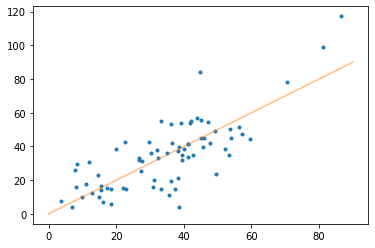

In [524]:
plt.plot(model.predict(x), y, '.')
plt.plot([0,90],[0,90], alpha=0.5);

### 2. OLS(sklearn.LinearRegression)

In [557]:
from sklearn import linear_model
from scipy import stats

X=env_cultivate_mean_data_minmax[columns[:-1]]
y=env_cultivate_mean_data_minmax['leavesLength']

lm=linear_model.LinearRegression()
model=lm.fit(X,y)
printScores(model, X, y)

R^2:  0.9003996770488487
Mean MAE: 3.647 (3.270)
Mean RMSE: 6.298


In [558]:
lm.coef_

array([ 2.51288408, -2.32021109, -1.58629152, -0.07255854, -6.44547135,
        9.52303935, -6.86984008,  0.56793711,  9.90502867,  0.88670996,
        2.51530201, -2.73036352, 14.28725448, 23.78200583,  1.76196777,
        7.27318424])

In [353]:
params = np.append(lm.intercept_,lm.coef_)
predictions = lm.predict(X)

# newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
# MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

# Note if you don't want to use a DataFrame replace the two lines above with
newX = np.append(np.ones((len(X),1)), X, axis=1)
MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [params,sd_b,ts_b,p_values]
print(myDF3)

#결과출력
wow=[]
for i in range(len(p_values)):
    if p_values[i]<=0.05:
        wow.append(columns[i])
print(wow)

    Coefficients  Standard Errors  t values  Probabilities
0         8.5988            3.521     2.442          0.018
1         2.5129            2.955     0.850          0.399
2        -2.3202            3.383    -0.686          0.496
3        -1.5863            6.518    -0.243          0.809
4        -0.0726            3.976    -0.018          0.986
5        -6.4455            6.316    -1.020          0.312
6         9.5230            3.398     2.803          0.007
7        -6.8698            4.094    -1.678          0.099
8         0.5679            3.577     0.159          0.874
9         9.9050            7.422     1.334          0.187
10        0.8867            6.458     0.137          0.891
11        2.5153            1.882     1.337          0.187
12       -2.7304            1.900    -1.437          0.156
13       14.2873            3.297     4.333          0.000
14       23.7820            2.942     8.084          0.000
15        1.7620            2.006     0.879          0.3

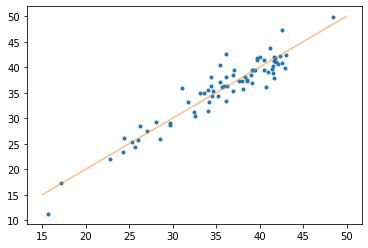

In [546]:
plt.plot(lm.predict(X), y, '.')
plt.plot([15,50],[15,50], alpha=0.5);

In [527]:
from sklearn import linear_model
from scipy import stats

X=env_cultivate_mean_data_minmax[columns[:-1]]
y=env_cultivate_mean_data_minmax['fruitsNum']

lm=linear_model.LinearRegression()
lm.fit(X,y)
printScores(lm, X, y)

R^2:  0.6335808382721407
Mean MAE: 25.087 (24.901)
Mean RMSE: 45.473


In [355]:
params = np.append(lm.intercept_,lm.coef_)
predictions = lm.predict(X)

# newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
# MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

# Note if you don't want to use a DataFrame replace the two lines above with
newX = np.append(np.ones((len(X),1)), X, axis=1)
MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [params,sd_b,ts_b,p_values]
print(myDF3)

#결과출력
wow=[]
for i in range(len(p_values)):
    if p_values[i]<=0.05:
        wow.append(columns[i])
print(wow)
#내부CO2, 외부온도, 외부풍향

    Coefficients  Standard Errors  t values  Probabilities
0        46.8548           21.213     2.209          0.031
1        12.4760           17.804     0.701          0.486
2       -11.5106           20.385    -0.565          0.575
3        24.7576           39.273     0.630          0.531
4       -11.8782           23.958    -0.496          0.622
5        82.6006           38.058     2.170          0.034
6        15.9391           20.475     0.778          0.440
7        -8.4517           24.670    -0.343          0.733
8       -53.1452           21.551    -2.466          0.017
9       -88.4977           44.724    -1.979          0.053
10      -41.6590           38.910    -1.071          0.289
11       22.3334           11.338     1.970          0.054
12       -8.3333           11.449    -0.728          0.470
13       51.6565           19.866     2.600          0.012
14      -47.9017           17.727    -2.702          0.009
15       13.6895           12.085     1.133          0.2

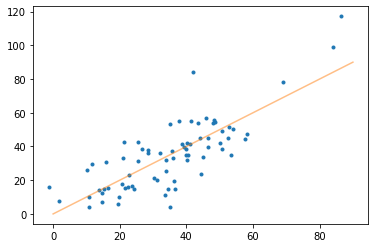

In [528]:
plt.plot(lm.predict(X), y, '.')
plt.plot([0,90],[0,90], alpha=0.5);

### 3. LASSO(sklearn)

In [543]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

#leavesLength, fruitsNum
X=env_cultivate_mean_data_minmax[columns[:-1]]
y=env_cultivate_mean_data_minmax['leavesLength']

clf=linear_model.Lasso(alpha=0.1, normalize=True)
clf.fit(X, y)

printScores(clf, X, y)

R^2:  0.8419370963719223
Mean MAE: 2.084 (0.629)
Mean RMSE: 2.759


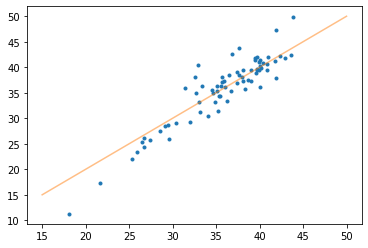

In [544]:
plt.plot(clf.predict(X), y, '.')
plt.plot([15,50],[15,50], alpha=0.5);

In [531]:
#leavesLength, fruitsNum
X=env_cultivate_mean_data_minmax[columns[:-1]]
y=env_cultivate_mean_data_minmax['fruitsNum']

clf=linear_model.Lasso(alpha=0.1, normalize=True)
clf.fit(X, y)

printScores(clf, X, y)

R^2:  0.5351336902152475
Mean MAE: 18.346 (14.011)
Mean RMSE: 29.052


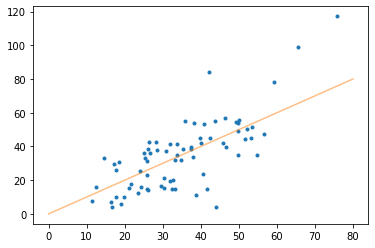

In [532]:
plt.plot(clf.predict(X), y, '.')
plt.plot([0,80],[0,80], alpha=0.5);

### 4. Robust Linear Regression

In [541]:
#leavesLength, fruitsNum
X=env_cultivate_mean_data_minmax[columns[:-1]]
y=env_cultivate_mean_data_minmax['leavesLength']
model = sm.RLM(y, X).fit()

r2=1. - np.sum(np.abs(model.predict(X) - y) **2) / np.sum(np.abs(y - np.mean(y)) ** 2)
print("r^2: ",r2)
model.summary()

r^2:  0.8855008175106986


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:           leavesLength   No. Observations:                   73
Model:                            RLM   Df Residuals:                       57
Method:                          IRLS   Df Model:                           15
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 20 Nov 2020                                         
Time:                        06:40:00                                         
No. Iterations:                    50                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
CI                 5.8553      2.294      2.552      0.011       1.358      10.352
EL                -6.4063      2.757     -2.324      0.020     -11.809      -1.003
HI                -4.6470      6.381     -0.728      0.466     -17.154       7.860
HL                 6.2192      3.356      1.853      0.064      -0.359      12.797
RP                -6.1611      6.238     -0.988      0.323     -18.387       6.064
TE                10.5056      3.164      3.320      0.001       4.304      16.707
TI                -4.7556      4.054     -1.173      0.241     -12.702       3.191
TL                 6.3395      2.780      2.281      0.023       0.891      11.788
WD                 8.5223      7.343      1.161      0.246      -5.869      22.914
WS                 6.0331      6.204      0.972      0.331      -6.127      18.194
growLength         2.1092      1.863      1.132      0.258      -1.543       5.761
flowerTop         -3.5193      1.872     -1.880      0.060      -7.188       0.149
stemDiameter      15.5164      3.254      4.769      0.000       9.140      21.893
leavesWidth       25.7580      2.755      9.350      0.000      20.358      31.158
leavesNum          5.0146      1.699      2.952      0.003       1.685       8.344
flowerPosition     7.1689      2.099      3.416      0.001       3.055      11.282
==================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

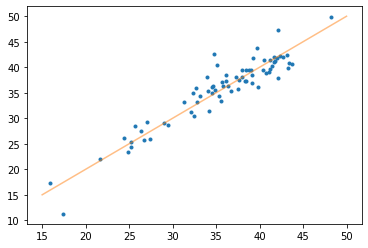

In [542]:
plt.plot(model.predict(X), y, '.')
plt.plot([15,50],[15,50], alpha=0.5)

In [535]:
#leavesLength, fruitsNum
x=env_cultivate_mean_data_minmax[columns[:-1]]
y=env_cultivate_mean_data_minmax['fruitsNum']
model = sm.RLM(y, X).fit()

r2=1. - np.sum(np.abs(model.predict(X) - y) **2) / np.sum(np.abs(y - np.mean(y)) ** 2)
print("r^2: ",r2)
model.summary()

r^2:  0.582818880028048


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:              fruitsNum   No. Observations:                   73
Model:                            RLM   Df Residuals:                       57
Method:                          IRLS   Df Model:                           15
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 20 Nov 2020                                         
Time:                        06:39:10                                         
No. Iterations:                    28                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
CI                33.5995     14.449      2.325      0.020       5.280      61.919
EL               -37.1702     17.360     -2.141      0.032     -71.194      -3.146
HI                 8.0374     40.186      0.200      0.841     -70.725      86.800
HL                19.4121     21.135      0.918      0.358     -22.012      60.837
RP                64.8571     39.280      1.651      0.099     -12.130     141.844
TE                32.4951     19.926      1.631      0.103      -6.559      71.549
TI               -10.1968     25.531     -0.399      0.690     -60.237      39.843
TL               -14.0825     17.505     -0.804      0.421     -48.392      20.227
WD               -70.3889     46.240     -1.522      0.128    -161.017      20.239
WS               -13.1495     39.071     -0.337      0.736     -89.727      63.428
growLength        22.7557     11.734      1.939      0.052      -0.242      45.753
flowerTop        -11.5473     11.788     -0.980      0.327     -34.650      11.556
stemDiameter      47.5429     20.488      2.320      0.020       7.387      87.699
leavesWidth      -33.0122     17.349     -1.903      0.057     -67.015       0.991
leavesNum         29.0777     10.699      2.718      0.007       8.109      50.047
flowerPosition    49.5983     13.217      3.753      0.000      23.694      75.503
==================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

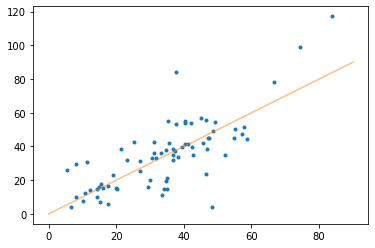

In [536]:
plt.plot(model.predict(X), y, '.')
plt.plot([0,90],[0,90], alpha=0.5)

### 5. Random Forest Regression

In [537]:
from sklearn.ensemble import RandomForestRegressor

#leavesLength, fruitsNum
x=env_cultivate_mean_data_minmax[columns[:-1]]
y=env_cultivate_mean_data_minmax['leavesLength']

regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X, y)

printScores(regr, X, y)

R^2:  0.8750427873734471
Mean MAE: 2.395 (0.789)
Mean RMSE: 3.156


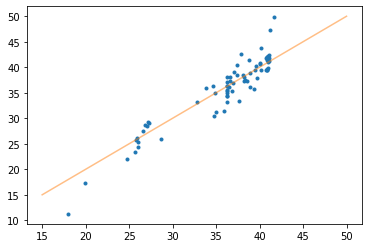

In [539]:
plt.plot(regr.predict(X), y, '.')
plt.plot([15,50],[15,50], alpha=0.5)

In [494]:
from sklearn.ensemble import RandomForestRegressor

#leavesLength, fruitsNum
x=env_cultivate_mean_data_minmax[columns[:-1]]
y=env_cultivate_mean_data_minmax['fruitsNum']

regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(x, y)

printScores(regr, x, y)

R^2:  0.6723985508054479
Mean MAE: 13.484 (4.286)
Mean RMSE: 16.547


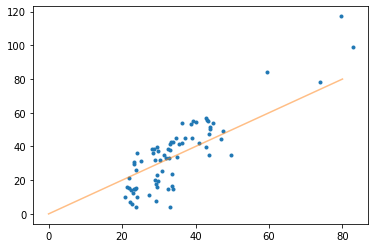

In [495]:
plt.plot(regr.predict(x), y, '.')
plt.plot([0,80],[0,80], alpha=0.5)

### 6. Support Vector Regression

In [492]:
from sklearn.svm import SVR

#leavesLength, fruitsNum
x=env_cultivate_mean_data_minmax[columns[:-1]]
y=env_cultivate_mean_data_minmax['leavesLength']

svm = SVR(kernel='poly', degree=5, epsilon=0.1)
svm.fit(x,y)

printScores(svm, x, y)

R^2:  0.9537785223449676
Mean MAE: 2.674 (0.948)
Mean RMSE: 3.367


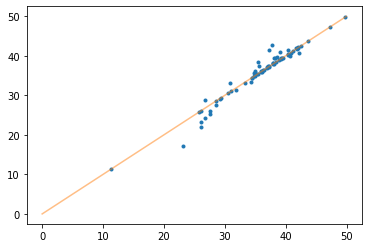

In [493]:
plt.plot(svm.predict(x), y, '.')
plt.plot([0,50],[0,50], alpha=0.5)

In [455]:
from sklearn.svm import SVR

#leavesLength, fruitsNum
x=env_cultivate_mean_data_minmax[columns[:-1]]
y=env_cultivate_mean_data_minmax['fruitsNum']

svm = SVR(kernel='poly', degree=6, epsilon=0.1)
svm.fit(x,y)

printScores(svm, x, y)

R^2:  0.8604513164947923
Mean MAE: 13.238 (5.061)
Mean RMSE: 17.382


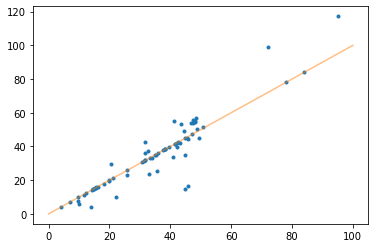

In [488]:
plt.plot(svm.predict(x), y, '.')
plt.plot([0,100],[0,100], alpha=0.5)

### 7. Elastic Net

In [549]:
from sklearn.linear_model import ElasticNetCV

#leavesLength, fruitsNum
x=env_cultivate_mean_data_minmax[columns[:-1]]
y=env_cultivate_mean_data_minmax['leavesLength']

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# define model
ratios = arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1)
# fit model
model.fit(X, y)
# summarize chosen configuration
print('alpha: %f' % model.alpha_)
print('l1_ratio_: %f' % model.l1_ratio_)

alpha: 0.100000
l1_ratio_: 0.990000


In [550]:
regr = ElasticNet(alpha=0.1, l1_ratio=0.99)
regr.fit(x,y)

printScores(regr, x, y)

R^2:  0.8545748457729686
Mean MAE: 2.075 (0.587)
Mean RMSE: 2.698


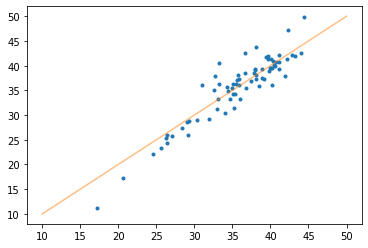

In [554]:
plt.plot(regr.predict(x), y, '.')
plt.plot([10,50],[10,50], alpha=0.5)

In [471]:
from sklearn.linear_model import ElasticNetCV

#leavesLength, fruitsNum
x=env_cultivate_mean_data_minmax[columns[:-1]]
y=env_cultivate_mean_data_minmax['fruitsNum']

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# define model
ratios = arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1)
# fit model
model.fit(X, y)
# summarize chosen configuration
print('alpha: %f' % model.alpha_)
print('l1_ratio_: %f' % model.l1_ratio_)

alpha: 0.010000
l1_ratio_: 0.020000


In [474]:
regr = ElasticNet(alpha=0.01, l1_ratio=0.02)
regr.fit(x,y)

printScores(regr, x, y)

R^2:  0.5481413505939001
Mean MAE: 12.968 (3.338)
Mean RMSE: 16.659


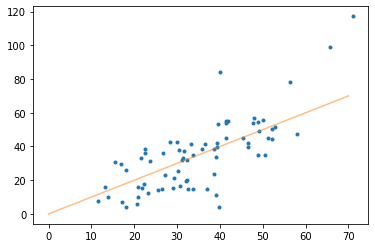

In [490]:
plt.plot(regr.predict(x), y, '.')
plt.plot([0,70],[0,70], alpha=0.5)